In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

In [2]:
import nasdaqdatalink
import quandl

nasdaqdatalink.api_key = 'M3geuff1prDgYkajPZNu'
quandl.ApiConfig.api_key = 'M3geuff1prDgYkajPZNu'
FRED_api = 'c4a3900347be8d17b1426b4536bcc12b'

In [3]:
# get current date in format YYYY-MM-DD
from datetime import datetime
current_date = datetime.now().strftime('%Y-%m-%d')
current_date

'2023-11-29'

In [4]:
# get real GDP data from FRED
base_url = 'https://api.stlouisfed.org/fred/series/observations?'

In [5]:
def get_FRED_data(series_id, start_date = '1996-01-01', end_date = current_date, units = 'lin', fill_na = True):
    base_url = 'https://api.stlouisfed.org/fred/series/observations?'
    req = requests.get(
        base_url,
        params={
            'api_key': FRED_api,
            'series_id': series_id,
            'file_type': 'json',
            'observation_start': start_date,
            'observation_end': end_date,
            'units': units,
        }
    )
    data = req.json()
    data = pd.DataFrame(data['observations'])
    data.drop(columns = 'realtime_start', inplace = True)
    data.drop(columns = 'realtime_end', inplace = True)
    data['date'] = pd.to_datetime(data['date'])
    data.rename(columns={'value': series_id}, inplace=True)
    #data.set_index('date', inplace = True)
    if fill_na:
        data[series_id].ffill(inplace = True)
    return data

In [6]:
def merge_data(data_dict, series_id_list):
    data = data_dict[series_id_list[0]]
    # merge data
    for series_id in series_id_list[1:]:
        data = data.merge(data_dict[series_id], how = 'left', on = 'date')

    # convert data to float
    for series_id in series_id_list:
        data[series_id] = data[series_id].astype(float)
    return data

In [7]:
def get_data(data_unit, fill_na = True):
    series_id_list = ['FEDFUNDS', 'GDPC1', 'UNRATE', 'MEDCPIM158SFRBCLE', 'RSAFS', 'UMCSENT']
    series_dict = {}
    for series_id in series_id_list:
        series_dict[series_id] = get_FRED_data(series_id, units=data_unit)
    data = merge_data(series_dict, series_id_list)
    return data

In [8]:
lin_data = get_data('lin', fill_na = True)
percent_year = get_data('pc1', fill_na = True)
percent_month = get_data('pch', fill_na = True)

In [9]:
lin_data.head()

,date,FEDFUNDS,GDPC1,UNRATE,MEDCPIM158SFRBCLE,RSAFS,UMCSENT
0,1996-01-01,5.56,11614.418,5.6,3.775768,208699.0,89.3
1,1996-02-01,5.22,NaN,5.5,2.618961,212008.0,88.5
2,1996-03-01,5.31,NaN,5.5,3.110565,213891.0,93.7
3,1996-04-01,5.22,11808.140,5.6,3.133276,214676.0,92.7
4,1996-05-01,5.24,NaN,5.6,2.937790,216299.0,89.4


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_data(data):
    series_id_dict = {'FEDFUNDS': 'Federal Funds Rate',
                  'GDPC1': 'Real GDP', 
                  'UNRATE': 'Unemployment Rate',
                  'MEDCPIM158SFRBCLE': 'Median CPI', 
                  'RSAFS': 'Advance Retail Sales: Retail Trade and food service', 
                  'UMCSENT': 'Consumer Sentiment',
                  }
    columns = data.columns
    fig, axs = plt.subplots(2, 3, figsize = (15, 10))
    axs = axs.flatten()
    for i in range(1, len(columns)):
        axs[i-1].plot(data['date'], data[columns[i]])
        axs[i-1].set_title(series_id_dict[columns[i]])
    plt.tight_layout()
    plt.show()      

**FEDFUNDS**: Federal Reserve Rate

**GPDC1**: Real GDP

**UNRATE**: Unemployment Rate

**MEDCPIM158SFRBCLE**: Median CPI

**RSAFS**:Advance Retail Sales: Retail Trade and food service

**UMCSENT**: Consumer Sentiment

**DPCCRV1Q225SBEA**: PCE Excluding Food and Energy

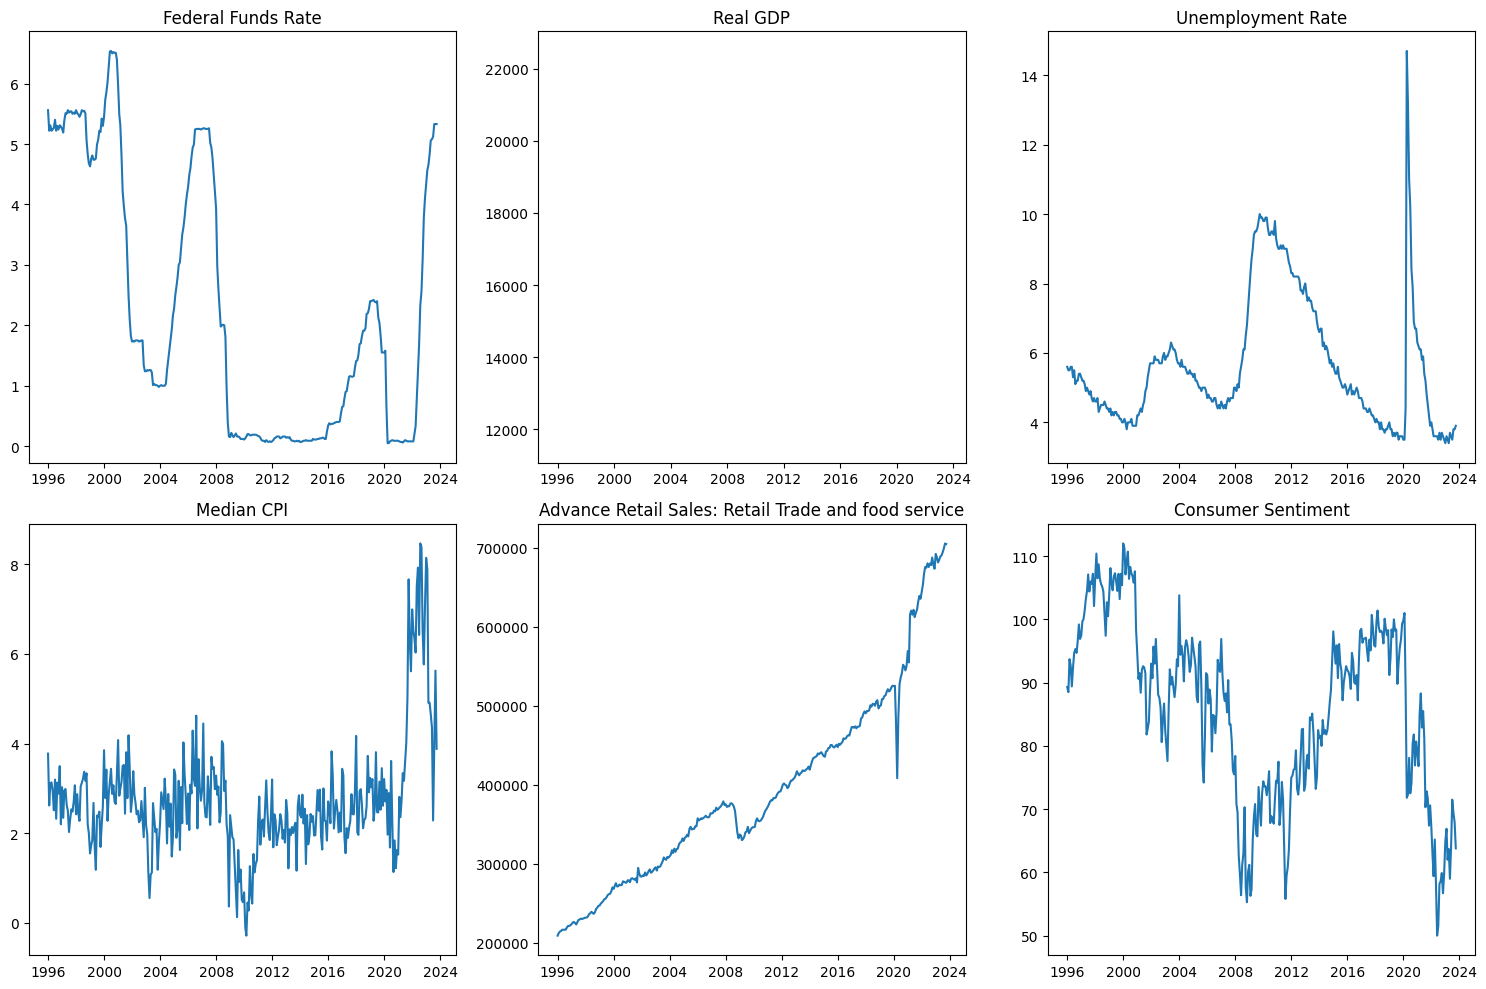

In [11]:
plot_data(lin_data)

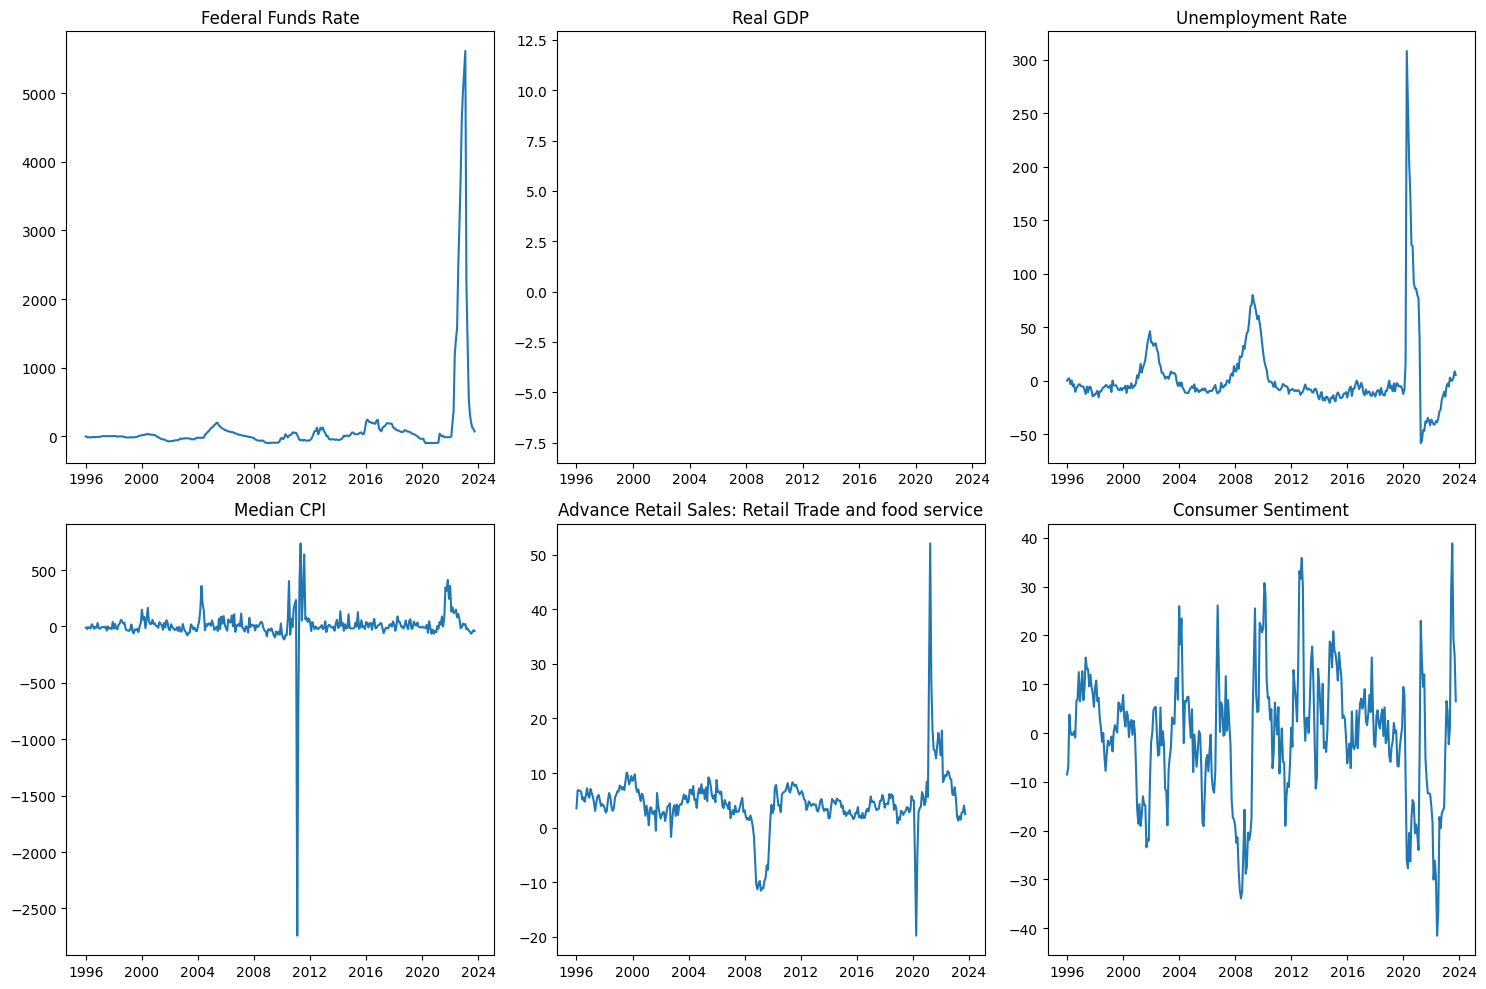

In [12]:
plot_data(percent_year)

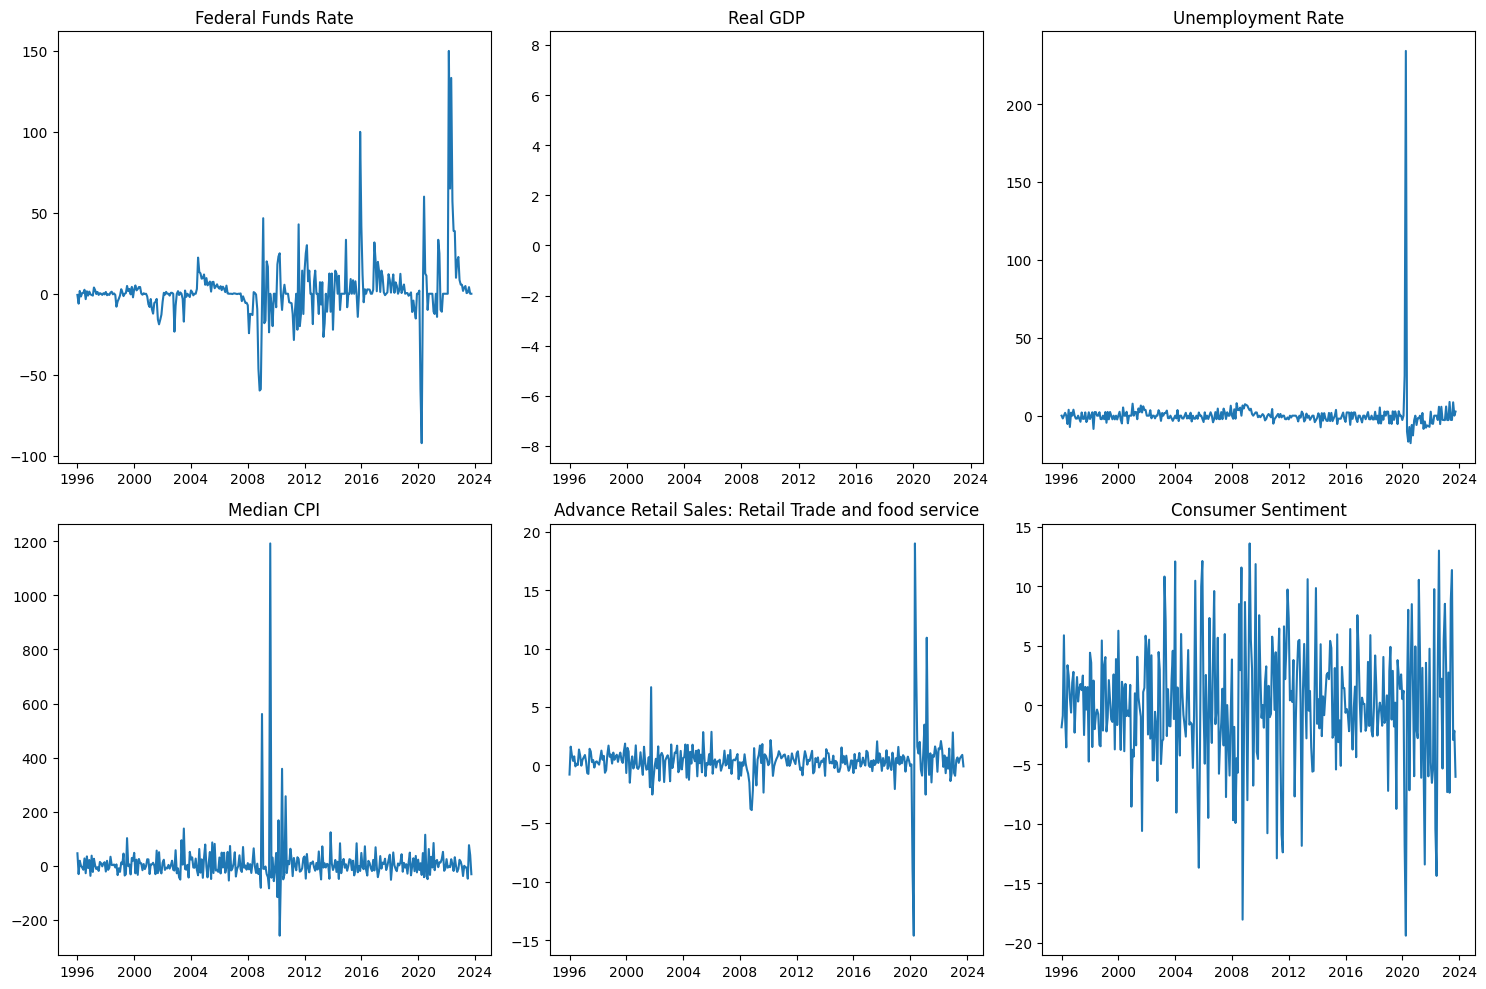

In [13]:
plot_data(percent_month)

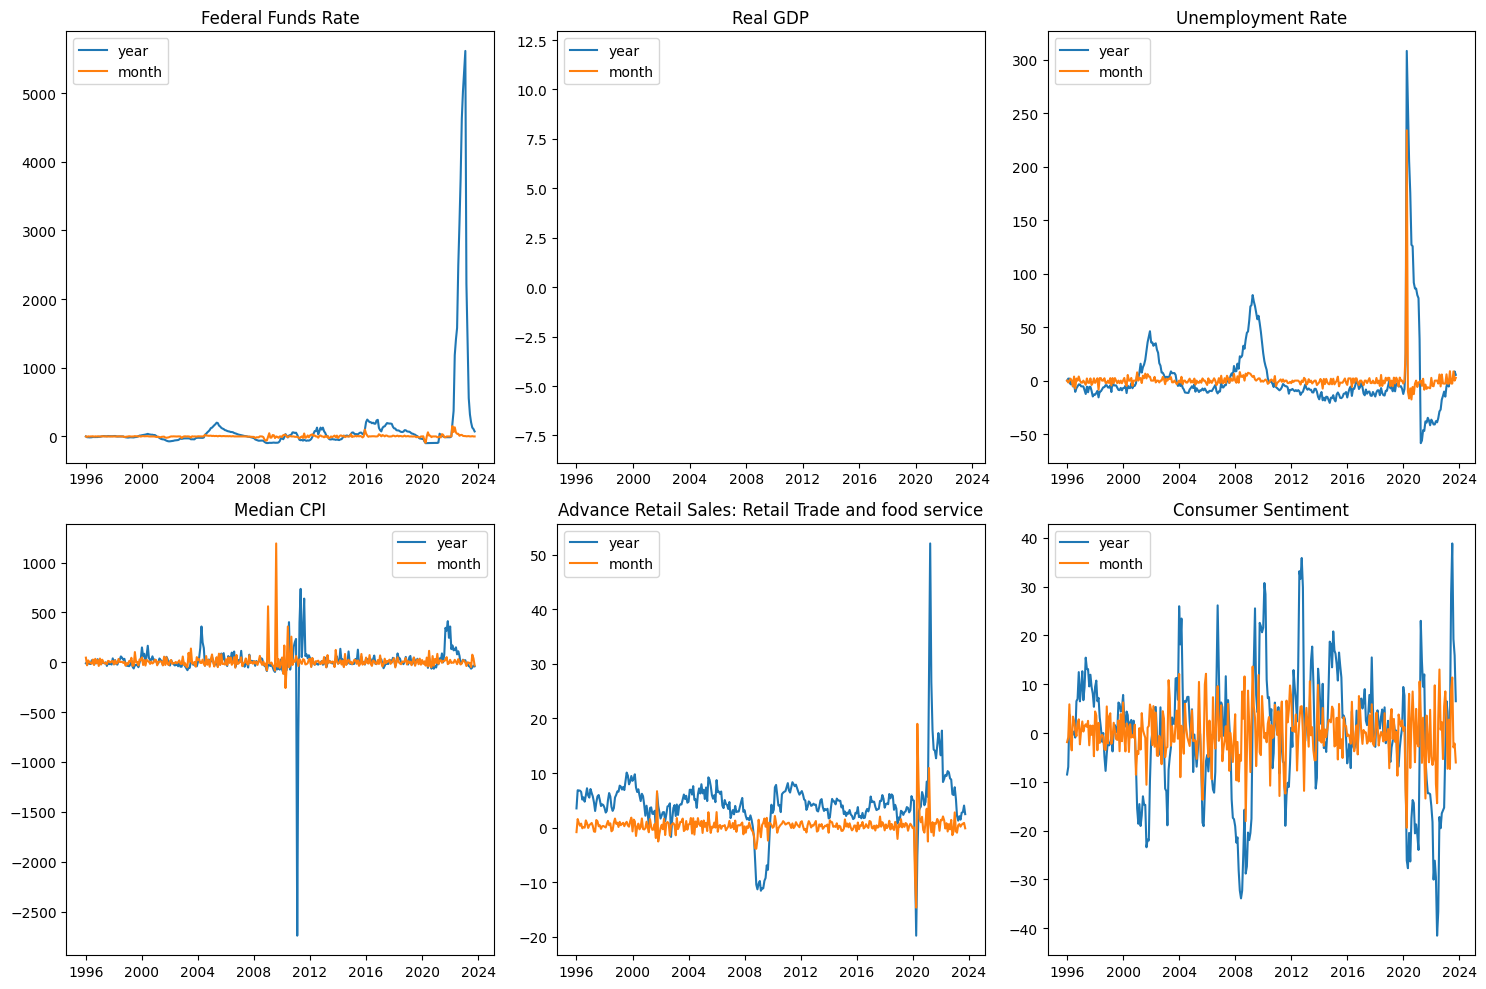

In [14]:
percent_year_month = percent_year.merge(percent_month, how = 'left', on = 'date', suffixes=('_year', '_month'))
percent_year_month.head()
# plot data by date, year and month in same subplot for each series_id
def plot_data_year_month(data):
    series_id_dict = {'FEDFUNDS': 'Federal Funds Rate',
                  'GDPC1': 'Real GDP', 
                  'UNRATE': 'Unemployment Rate',
                  'MEDCPIM158SFRBCLE': 'Median CPI', 
                  'RSAFS': 'Advance Retail Sales: Retail Trade and food service', 
                  'UMCSENT': 'Consumer Sentiment',
#                  'DPCCRV1Q225SBEA': 'PCE Excluding Food and Energy'
                  }
    fig, axs = plt.subplots(2, 3, figsize = (15, 10))
    axs = axs.flatten()
    for ii, key in enumerate(series_id_dict.keys()):
        #print(ii, key)
        axs[ii].plot(data['date'], data[key + '_year'], label = 'year')
        axs[ii].plot(data['date'], data[key + '_month'], label = 'month')
        axs[ii].set_title(series_id_dict[key])
        axs[ii].legend()
    plt.tight_layout()
    plt.show()
plot_data_year_month(percent_year_month)

<Axes: >

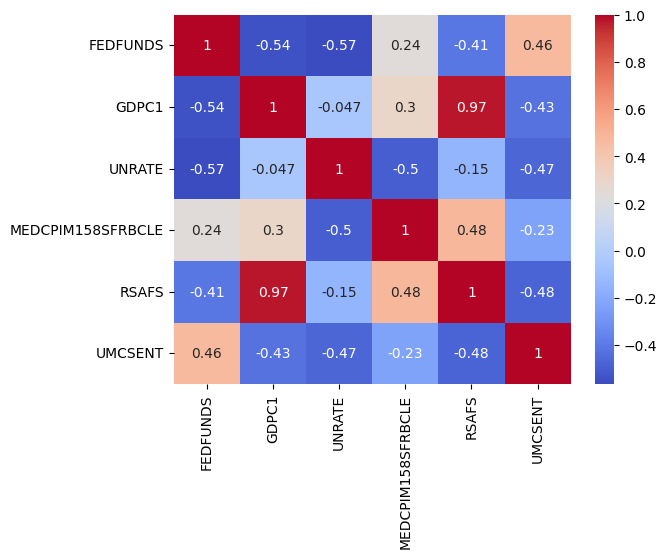

In [15]:
sns.heatmap(lin_data.iloc[:,1:].corr(), annot = True, cmap = 'coolwarm')

In [23]:
# ipynb ignore warinig
import warnings
warnings.filterwarnings('ignore')

In [24]:
FED_all = pd.read_excel('effective_rate.xlsx')

In [26]:
FED_use = FED_all[['Effective Date', 'Target Rate From (%)','Target Rate To (%)']]
FED_use.rename(columns={'Effective Date': 'date','Target Rate From (%)' : 'target_upper','Target Rate To (%)':'target_lower'}, inplace=True)
FED_use['date'] = pd.to_datetime(FED_use['date'])

In [20]:
potential_GDP = get_FRED_data('GDPPOT')

In [32]:
potential_GDP.head()

,date,GDPPOT
0,1996-01-01,10879.309158135062
1,1996-04-01,10961.169452731983
2,1996-07-01,11050.502724170348
3,1996-10-01,11145.657938016473
4,1997-01-01,11244.924013707889


In [29]:
# sort the FED_use by from 2000-01-01
FED_use = FED_use.sort_values(by = 'date')
FED_use.head()

,date,target_upper,target_lower
5882,2000-07-03,6.5,NaN
5881,2000-07-05,6.5,NaN
5880,2000-07-06,6.5,NaN
5879,2000-07-07,6.5,NaN
5878,2000-07-10,6.5,NaN


In [31]:
full_df = (pd.merge_asof(lin_data, FED_use, on='date', direction='nearest')
           .merge(percent_year_month, how = 'left', on = 'date')
           .merge(potential_GDP, how = 'left', on = 'date')
           )
full_df.head()

,date,FEDFUNDS,GDPC1,UNRATE,MEDCPIM158SFRBCLE,RSAFS,UMCSENT,target_upper,target_lower,FEDFUNDS_year,...,MEDCPIM158SFRBCLE_year,RSAFS_year,UMCSENT_year,FEDFUNDS_month,GDPC1_month,UNRATE_month,MEDCPIM158SFRBCLE_month,RSAFS_month,UMCSENT_month,GDPPOT
0,1996-01-01,5.56,11614.418,5.6,3.775768,208699.0,89.3,6.5,NaN,0.54250,...,-9.80430,3.53520,-8.50410,-0.71429,0.74905,0.00000,46.36763,-0.80799,-1.86813,10879.309158135062
1,1996-02-01,5.22,NaN,5.5,2.618961,212008.0,88.5,6.5,NaN,-11.82432,...,-21.53243,6.85941,-6.94006,-6.11511,NaN,-1.78571,-30.63766,1.58554,-0.89586,NaN
2,1996-03-01,5.31,NaN,5.5,3.110565,213891.0,93.7,6.5,NaN,-11.20401,...,-4.71751,6.81359,3.76523,1.72414,NaN,0.00000,18.77096,0.88817,5.87571,NaN
3,1996-04-01,5.22,11808.140,5.6,3.133276,214676.0,92.7,6.5,NaN,-13.71901,...,-14.35650,6.78698,0.21622,-1.69492,1.66794,1.81818,0.73012,0.36701,-1.06724,10961.169452731983
4,1996-05-01,5.24,NaN,5.6,2.937790,216299.0,89.4,6.5,NaN,-12.81198,...,-17.46535,6.55858,-0.44543,0.38314,NaN,0.00000,-6.23902,0.75602,-3.55987,NaN


In [33]:
full_df.to_csv('full_df.csv')